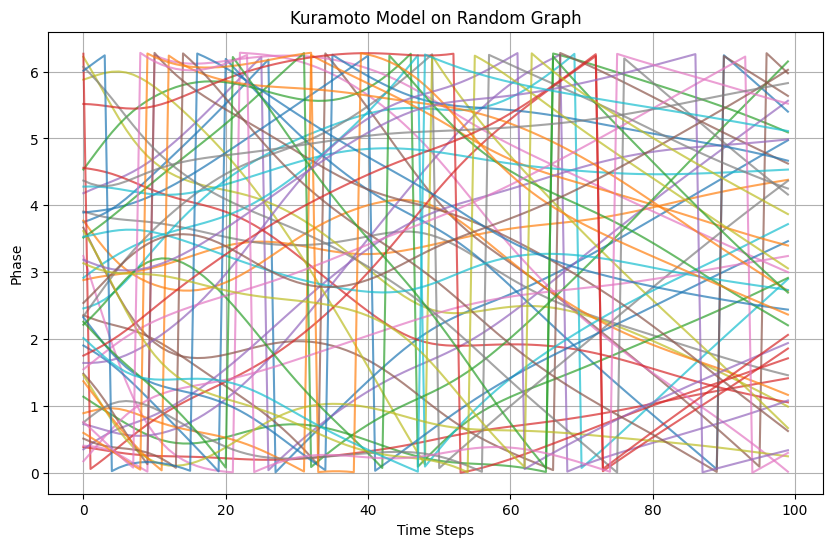

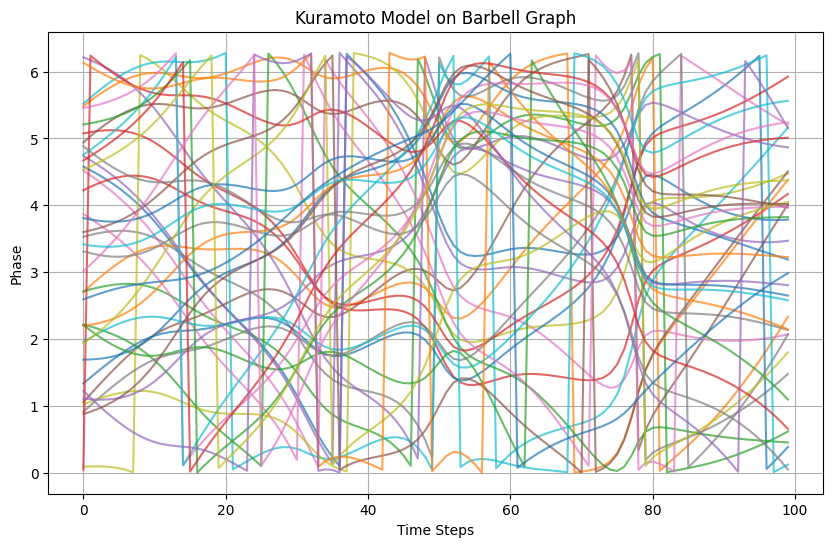

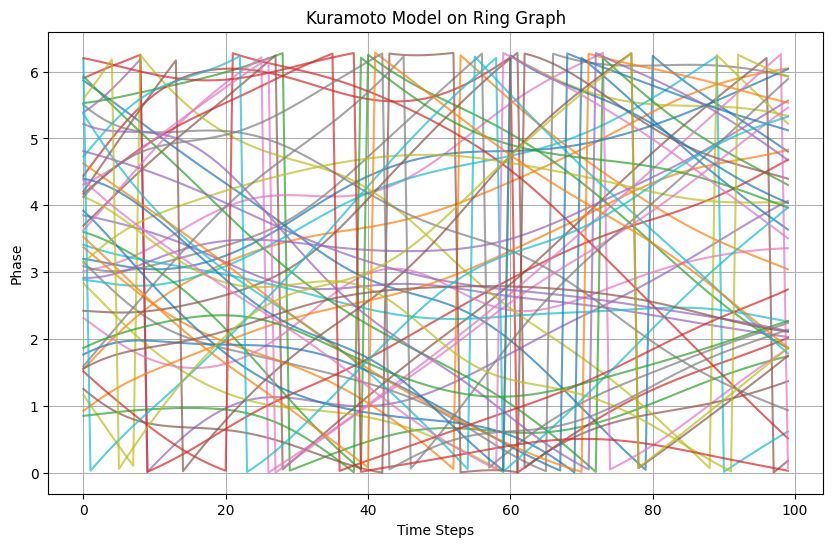

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def kuramoto_simulation(graph, K, timesteps, dt):
    """
    Simulate the Kuramoto model on a network.
    Parameters:
        graph: NetworkX graph object.
        K: Coupling constant.
        timesteps: Number of timesteps.
        dt: Time step size.
    Returns:
        A 2D numpy array with shape (N, timesteps), where each row represents the phase of an oscillator over time.
    """
    N = graph.number_of_nodes()
    A = nx.to_numpy_array(graph)  # Adjacency matrix
    natural_frequencies = np.random.uniform(-1, 1, N)  # Random natural frequencies
    phases = np.random.uniform(0, 2 * np.pi, N)  # Initial random phases
    
    phase_history = np.zeros((N, timesteps))
    phase_history[:, 0] = phases

    for t in range(1, timesteps):
        dtheta = natural_frequencies + (K / N) * np.sum(
            A @ np.sin(np.subtract.outer(phases, phases)), axis=1
        )
        phases += dtheta * dt
        phases = phases % (2 * np.pi)  # Keep phases within [0, 2π]
        phase_history[:, t] = phases

    return phase_history

def plot_kuramoto_results(phase_history, title):
    """
    Plot the synchronization dynamics for the Kuramoto model.
    """
    plt.figure(figsize=(10, 6))
    for i in range(phase_history.shape[0]):
        plt.plot(phase_history[i], label=f"Oscillator {i}", alpha=0.7)
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Phase")
    plt.grid()
    plt.show()

# Simulation parameters
timesteps = 100
dt = 0.1
K = 2.0  # Coupling strength

# Generate network topologies
random_graph = nx.erdos_renyi_graph(n=50, p=0.1)
barbell_graph = nx.barbell_graph(m1=20, m2=1)
ring_graph = nx.cycle_graph(n=50)

# Simulate Kuramoto model
phases_random = kuramoto_simulation(random_graph, K, timesteps, dt)
phases_barbell = kuramoto_simulation(barbell_graph, K, timesteps, dt)
phases_ring = kuramoto_simulation(ring_graph, K, timesteps, dt)

# Plot synchronization results
plot_kuramoto_results(phases_random, "Kuramoto Model on Random Graph")
plot_kuramoto_results(phases_barbell, "Kuramoto Model on Barbell Graph")
plot_kuramoto_results(phases_ring, "Kuramoto Model on Ring Graph")


In [2]:
# Standard Library
import random
from collections import defaultdict
from copy import copy

# Third Party
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib import cm
from scipy.interpolate import splprep, splev
from scipy.spatial import ConvexHull


##################
# COMMUNITY LAYOUT
##################


def _inter_community_edges(G, partition):
    edges = defaultdict(list)

    for (i, j) in G.edges():
        c_i = partition[i]
        c_j = partition[j]

        if c_i == c_j:
            continue

        edges[(c_i, c_j)].append((i, j))

    return edges


def _position_communities(G, partition, **kwargs):
    hypergraph = nx.Graph()
    hypergraph.add_nodes_from(set(partition))

    inter_community_edges = _inter_community_edges(G, partition)
    for (c_i, c_j), edges in inter_community_edges.items():
        hypergraph.add_edge(c_i, c_j, weight=len(edges))

    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # Set node positions to positions of its community
    pos = dict()
    for node, community in enumerate(partition):
        pos[node] = pos_communities[community]

    return pos


def _position_nodes(G, partition, **kwargs):
    communities = defaultdict(list)
    for node, community in enumerate(partition):
        communities[community].append(node)

    pos = dict()
    for c_i, nodes in communities.items():
        subgraph = G.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos


# Adapted from: https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx
def community_layout(G, partition):
    pos_communities = _position_communities(G, partition, scale=10.0)
    pos_nodes = _position_nodes(G, partition, scale=2.0)

    # Combine positions
    pos = dict()
    for node in G.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos


#########
# PATCHES
#########


def _node_coordinates(nodes):
    collection = copy(nodes)
    collection.set_offset_position("data")
    return collection.get_offsets()


def _convex_hull_vertices(node_coordinates, community):
    points = np.array(node_coordinates[list(community)])
    hull = ConvexHull(points)

    x, y = points[hull.vertices, 0], points[hull.vertices, 1]
    vertices = np.column_stack((x, y))

    return vertices


# https://en.wikipedia.org/wiki/Shoelace_formula#Statement
def _convex_hull_area(vertices):
    A = 0.0
    for i in range(-1, vertices.shape[0] - 1):
        A += vertices[i][0] * (vertices[i + 1][1] - vertices[i - 1][1])

    return A / 2


# https://en.wikipedia.org/wiki/Centroid#Of_a_polygon
def _convex_hull_centroid(vertices):
    A = _convex_hull_area(vertices)

    c_x, c_y = 0.0, 0.0
    for i in range(vertices.shape[0]):
        x_i, y_i = vertices[i]
        if i == vertices.shape[0] - 1:
            x_i1, y_i1 = vertices[0]
        else:
            x_i1, y_i1 = vertices[i + 1]

        cross = ((x_i * y_i1) - (x_i1 * y_i))

        c_x += (x_i + x_i1) * cross
        c_y += (y_i + y_i1) * cross

    return c_x / (6 * A), c_y / (6 * A)


def _scale_convex_hull(vertices, offset):
    c_x, c_y = _convex_hull_centroid(vertices)
    for i, vertex in enumerate(vertices):
        v_x, v_y = vertex

        if v_x > c_x:
            vertices[i][0] += offset
        else:
            vertices[i][0] -= offset
        if v_y > c_y:
            vertices[i][1] += offset
        else:
            vertices[i][1] -= offset

    return vertices


def _community_patch(vertices):
    vertices = _scale_convex_hull(vertices, 1) # TODO: Make offset dynamic
    tck, u = splprep(vertices.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, der=0)

    path = Path(np.column_stack((x_new, y_new)))
    patch = PathPatch(path, alpha=0.50, linewidth=0.0)
    return patch


def draw_community_patches(nodes, communities, axes):
    node_coordinates = _node_coordinates(nodes)
    vertex_sets = []
    for c_i, community in enumerate(communities):
        vertices = _convex_hull_vertices(node_coordinates, community)
        patch = _community_patch(vertices)
        patch.set_facecolor(nodes.to_rgba(c_i))

        axes.add_patch(patch)
        vertex_sets.append(patch.get_path().vertices)

    _vertices = np.concatenate(vertex_sets)
    xlim = [_vertices[:, 0].min(), _vertices[:, 0].max()]
    ylim = [_vertices[:, 1].min(), _vertices[: ,1].max()]

    axes.set_xlim(xlim)
    axes.set_ylim(ylim)


##################
# DRAW COMMUNITIES
##################


def draw_communities(adj_matrix, communities, dark=False, filename=None, dpi=None, seed=1):
    np.random.seed(seed)
    random.seed(seed)

    G = nx.from_numpy_matrix(adj_matrix)
    partition = [0 for _ in range(G.number_of_nodes())]
    for c_i, nodes in enumerate(communities):
        for i in nodes:
            partition[i] = c_i

    plt.rcParams["figure.facecolor"] = "black" if dark else "white"
    plt.rcParams["axes.facecolor"] = "black" if dark else "white"

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis("off")

    node_size = 10200 / G.number_of_nodes()
    linewidths = 34 / G.number_of_nodes()

    pos = community_layout(G, partition)
    nodes = nx.draw_networkx_nodes(
        G,
        pos=pos,
        node_color=partition,
        linewidths=linewidths,
        cmap=cm.jet,
        ax=ax
    )
    nodes.set_edgecolor("w")
    edges = nx.draw_networkx_edges(
        G,
        pos=pos,
        edge_color=(1.0, 1.0, 1.0, 0.75) if dark else (0.6, 0.6, 0.6, 1.0),
        width=linewidths,
        ax=ax
    )
    draw_community_patches(nodes, communities, ax)

    if not filename:
        plt.show()
    else:
        plt.savefig(filename, dpi=dpi)

    return ax

    # Standard Library
from itertools import combinations, chain
from collections import defaultdict

# Third Party
import numpy as np




#########
# HELPERS
#########


def initialize_node_to_comm(adj_matrix):
    return list(range(len(adj_matrix)))


def invert_node_to_comm(node_to_comm):
    communities = defaultdict(set)
    for node, community in enumerate(node_to_comm):
        communities[community].add(node)

    return list(communities.values())


def get_all_edges(nodes):
    return chain(combinations(nodes, 2), ((u, u) for u in nodes))


########
# PHASES
########


def run_first_phase(node_to_comm, adj_matrix, n, force_merge=False):
    M = modularity_matrix(adj_matrix)
    best_node_to_comm = node_to_comm.copy()
    num_communities = len(set(best_node_to_comm))
    is_updated = not (n and num_communities == n)
    ani_frames = [{"C": best_node_to_comm, "Q": 0.0}]

    # QUESTION: Randomize the order of the nodes before iterating?
    while is_updated:
        is_updated = False
        for i, neighbors in enumerate(adj_matrix):
            num_communities = len(set(best_node_to_comm))
            if n and num_communities == n:
                break

            best_Q = modularity(M, invert_node_to_comm(best_node_to_comm))
            max_delta_Q = 0.0
            updated_node_to_comm, visited_communities = best_node_to_comm, set()
            for j, weight in enumerate(neighbors):
                # Skip if self-loop or not neighbor
                if i == j or not weight:
                    continue

                neighbor_comm = best_node_to_comm[j]
                if neighbor_comm in visited_communities:
                    continue

                # Remove node i from its community and place it in the community
                # of its neighbor j
                candidate_node_to_comm = best_node_to_comm.copy()
                candidate_node_to_comm[i] = neighbor_comm

                candidate_Q = modularity(
                    M,
                    invert_node_to_comm(candidate_node_to_comm)
                )
                delta_Q = candidate_Q - best_Q
                if delta_Q > max_delta_Q or (force_merge and not max_delta_Q):
                    updated_node_to_comm = candidate_node_to_comm
                    max_delta_Q = delta_Q

                    ani_frames.append({
                        "C": candidate_node_to_comm,
                        "Q": candidate_Q
                    })

                visited_communities.add(neighbor_comm)

            # Set Q for first frame
            if not i and ani_frames[0]["C"] == best_node_to_comm:
                ani_frames[0]["Q"] = best_Q

            if best_node_to_comm != updated_node_to_comm:
                best_node_to_comm = updated_node_to_comm
                is_updated = True

    if ani_frames[-1]["C"] != best_node_to_comm:
        ani_frames.append({"C": best_node_to_comm, "Q": best_Q})

    return best_node_to_comm, ani_frames


def run_second_phase(node_to_comm, adj_matrix, true_partition, true_comms):
    comm_to_nodes = defaultdict(lambda: [])
    for i, comm in enumerate(node_to_comm):
        comm_to_nodes[comm].append(i)
    comm_to_nodes = list(comm_to_nodes.items())

    new_adj_matrix, new_true_partition = [], []
    for i, (comm, nodes) in enumerate(comm_to_nodes):
        true_nodes = {v for u in nodes for v in true_partition[u]}
        true_comms[i] = true_comms[comm]

        row_vec = []
        for j, (_, neighbors) in enumerate(comm_to_nodes):
            if i == j:  # Sum all intra-community weights and add as self-loop
                edge_weights = (adj_matrix[u][v]
                                for u, v in get_all_edges(nodes))
                edge_weight = 2 * sum(edge_weights)
            else:
                edge_weights = (adj_matrix[u][v]
                                for u in nodes for v in neighbors)
                edge_weight = sum(edge_weights)

            row_vec.append(edge_weight)

        new_true_partition.append(true_nodes)
        new_adj_matrix.append(row_vec)

    # TODO: Use numpy more efficiently
    return np.array(new_adj_matrix), new_true_partition, true_comms


######
# MAIN
######


def louvain_method(adj_matrix : np.ndarray, n : int = None) -> list:
    optimal_adj_matrix = adj_matrix
    node_to_comm = initialize_node_to_comm(adj_matrix)
    true_partition = [{i} for i in range(len(adj_matrix))]
    true_comms = {c: c for c in node_to_comm}

    M = modularity_matrix(adj_matrix)
    def update_frame(frame, partition, comm_aliases, recalculate_Q):
        true_node_to_comm = list(range(len(adj_matrix)))
        for i, community in enumerate(frame["C"]):
            for node in partition[i]:
                true_node_to_comm[node] = comm_aliases[community]

        frame["C"] = true_node_to_comm
        if recalculate_Q:
            frame["Q"] = modularity(M, invert_node_to_comm(frame["C"]))

        return frame

    ani_frames = []
    is_optimal = False
    while not is_optimal:
        optimal_node_to_comm, frames = run_first_phase(
            node_to_comm,
            optimal_adj_matrix,
            n
        )

        if optimal_node_to_comm == node_to_comm:
            if not n:
                frames = (update_frame(f, true_partition, true_comms, bool(ani_frames)) for f in frames)
                ani_frames.extend(frames)
                break

            optimal_node_to_comm, frames = run_first_phase(
                node_to_comm,
                optimal_adj_matrix,
                n,
                force_merge=True
            )

        frames = (update_frame(f, true_partition, true_comms, bool(ani_frames)) for f in frames)
        ani_frames.extend(frames)

        optimal_adj_matrix, true_partition, true_comms = run_second_phase(
            optimal_node_to_comm,
            optimal_adj_matrix,
            true_partition,
            true_comms
        )

        if n and len(true_partition) == n:
            break

        node_to_comm = initialize_node_to_comm(optimal_adj_matrix)

    return true_partition, ani_frames

